# Imports

In [116]:
# Data
import pandas as pd
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Stats
from scipy.stats import pearsonr
import statsmodels.formula.api as smf
from statsmodels.regression.mixed_linear_model import MixedLM
import optuna
# ML
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, roc_auc_score
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
import xgboost as xgb
import gpboost as gpb
# DL
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
# Misc
from tqdm import tqdm
from typing import Any, Tuple, Optional, List, Union, Dict # type tips
import warnings
from itertools import combinations
import logging
import os
import pickle

# Data

Note that data has been limited to days 5-81 (inclusive) out of the total 84 days.

- Early days involved learning how to do tasks and getting used to the interface/survey questions (i.e. calibrating responses). 
- Final days sometimes showed odd outliers that perhaps indicate that some subjects stopped responding accurately as they got very close to completion

In [3]:
# Specify path
path = '/Users/djw/Documents/pCloud_synced/Academics/Projects/2020_thesis/thesis_experiments/3_experiments/3_3_experience_sampling/3_3_2_processed_data/modeling/'

In [30]:
# Raw Data
df_raw = pd.read_csv(path + 'df_raw.csv')

# load undetrended data
df_undetrended = pd.read_csv(path + 'df_cleaned_no_outliers.csv')

# Processed (detrended) data
df = pd.read_csv(path + 'df_cleaned_no_outliers_detrended.csv')

# MLM results
mlm1_4 = pd.read_csv(path + 'mlm_1-4_feature.csv')

/var/folders/lw/ys_1b9sj08s904m4402qr0bm0000gn/T/ipykernel_13861/1765045058.py:2: DtypeWarning: Columns (45) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(path + 'df_raw.csv')


## Data Subsets

### Passive Features

In [34]:
# Passive features
passive_cols = [col for col in df.columns if 'passive' in col]

# Additional cols
additional_passive_cols = [
    'task_duration',
    'task_start_time',
    'task_end_time',
    'survey_complete',
    'tasks_complete',
    'watch_wearing'
]

# Create df_passive
passive_cols = passive_cols + additional_passive_cols

### Self Report Features

In [35]:
# create list of self report features
sr_cols = [col for col in df.columns if 'sr_' in col]

# remove affect self report features
sr_cols = [col for col in sr_cols if 'affect' not in col]

# remove social support features
sr_cols = [col for col in sr_cols if 'ss_' not in col]

# remove goal related features
sr_cols = [col for col in sr_cols if '_goal' not in col]

# List of self report features directly related to gap
gap_related_sr = [
    'sr_DAILY_past24_procrastination',
    'sr_DAILY_past24_productivity',
    'sr_DAILY_past24_punctuality',
    'sr_DAILY_past24_satisfaction',
    'sr_DAILY_past24_values',
    'sr_DAILY_past24_gapCause_internal',
    'sr_DAILY_past24_gapCause_external',
    'sr_DAILY_past24_gap',
    'sr_DAILY_past24_ideal',
    'sr_DAILY_past24_change',
    'sr_gap_heuristic',
    'sr_gap_heuristic_intercept',
    'sr_gap_heuristic_slope',
    'sr_DAILY_past48to24_gap',
    'sr_DAILY_past48to24_gapCause_internal',
    'sr_DAILY_past48to24_gapCause_external'
]

# remove self report that seem directly related to gap
sr_cols = [col for col in sr_cols if not any(gap_term in col for gap_term in gap_related_sr)]

# remove occupation features
sr_cols = [col for col in sr_cols if 'occupation' not in col]

# remove cols that are explicitly gaps
sr_cols = [col for col in sr_cols if '_gap' not in col]

### Task Data

In [36]:
task_cols = [col for col in df.columns if 'task_' in col]

# Remove columns containing '_model_' as these do not change by day
task_cols = [col for col in task_cols if '_model_' not in col]

# getting kernel error - remove task_hanoi_solved from task_cols
task_cols = [col for col in task_cols if 'task_hanoi_solved' not in col]

### Affect Features


In [37]:
# Affect features
affect_cols = [col for col in df.columns if 'affect_' in col]
affect_pm_cols = [col for col in df.columns if 'affect_' in col and not col.endswith('_am')]

# Helper Functions

In [7]:
def create_train_test_split(data: pd.DataFrame, target: str) -> tuple[pd.DataFrame, pd.DataFrame]:
    """Creates train/test splits for time series data on a per-participant basis.
    
    For each participant (PID):
    1. Finds their last day of data collection based on target variable
    2. Removes any data after their last valid day
    3. Creates an 80/20 chronological train/test split
    
    Args:
        data: DataFrame containing participant data with columns:
            - PID: Participant ID
            - day: Day number of study
            - target: Target variable to determine last valid day
        target: Name of target variable column
            
    Returns:
        tuple containing:
            - train_data: DataFrame with first 80% of each participant's data
            - test_data: DataFrame with last 20% of each participant's data
    """
    # Get last day of data collection for each PID based on target variable
    last_days = data.groupby('PID').agg({
        'day': lambda x: x[data[target].notna()].max()
    }).reset_index()

    # Remove any data after each PID's last day
    tt_filtered = pd.merge(
        data,
        last_days,
        on='PID',
        suffixes=('', '_last')
    )
    tt_filtered = tt_filtered[tt_filtered['day'] <= tt_filtered['day_last']]
    
    # Create train/test splits for each PID
    train_data = pd.DataFrame()
    test_data = pd.DataFrame()
    
    for pid in tt_filtered['PID'].unique():
        pid_data = tt_filtered[tt_filtered['PID'] == pid].copy()
        
        # Sort by day to ensure chronological split
        pid_data = pid_data.sort_values('day')
        
        # Calculate split point at 80%
        split_idx = int(len(pid_data) * 0.8)
        
        # Split the data
        train_pid = pid_data.iloc[:split_idx]
        test_pid = pid_data.iloc[split_idx:]
        
        # Append to main dataframes
        train_data = pd.concat([train_data, train_pid])
        test_data = pd.concat([test_data, test_pid])
        
    return train_data.reset_index(drop=True), test_data.reset_index(drop=True)

In [ ]:
def find_top_features(df, n_predictors=1, data_modality=None, min_observations=0, 
                      sort_by='abs_z_score', top_n=1, verbose=True):
    """
    Finds the top features from a results dataframe based on specified criteria.
    
    Parameters
    ----------
    df : pandas.DataFrame
        The dataframe containing model results
    n_predictors : int, default=1
        Number of predictors in the model to filter for
    data_modality : str or list, default=None
        Data modality to filter for (e.g., 'passive', 'sr'). If None, all modalities included.
    min_observations : int, default=0
        Minimum number of observations required
    sort_by : str, default='abs_z_score'
        Metric to sort by: 'abs_z_score', 'z_score', 'p_value', 'bic', 'aic', 'mean_error', etc.
    top_n : int, default=1
        Number of top features to return
    verbose : bool, default=True
        Whether to print results
        
    Returns
    -------
    pandas.DataFrame
        Dataframe containing the top_n features based on specified criteria
    """
    # Create a copy of the dataframe to avoid modifying the original
    results = df.copy()
    
    # Apply filtering conditions
    if n_predictors is not None:
        results = results[results['n_predictors'] == n_predictors]
        
    if data_modality is not None:
        if isinstance(data_modality, list):
            results = results[results['data_modality'].isin(data_modality)]
        else:
            results = results[results['data_modality'] == data_modality]
    
    if min_observations > 0:
        results = results[results['n_observations'] > min_observations]
    
    # Define metrics where smaller values are better
    smaller_is_better = ['bic', 'aic', 'mean_error', 'rmse', 'mae', 'p_value']
    
    # Create absolute z-score column if sorting by it
    if sort_by == 'abs_z_score':
        results['abs_z'] = results['z_score'].abs()
        sort_col = 'abs_z'
        use_smallest = False
    else:
        sort_col = sort_by
        use_smallest = sort_col.lower() in smaller_is_better
    
    # Check if sort column exists
    if sort_col not in results.columns:
        raise ValueError(f"Column '{sort_col}' not found in dataframe")
    
    # Get top features - using smallest for metrics where lower is better
    if use_smallest:
        top_features = results.nsmallest(top_n, sort_col)
    else:
        top_features = results.nlargest(top_n, sort_col)
    
    # Print results if verbose
    if verbose and len(top_features) > 0:
        modality_str = data_modality if data_modality else "all modalities"
        print(f"Top {top_n} features for {n_predictors}-predictor models with {modality_str}:")
        print(f"Minimum observations: {min_observations}, Sorted by: {sort_by}")
        print("\nResults:")
        
        for i, row in top_features.iterrows():
            print(f"\nRank {top_features.index.get_loc(i) + 1}:")
            
            # Print feature names based on n_predictors
            for j in range(1, n_predictors + 1):
                feature_col = f'feature_{j}'
                if feature_col in row:
                    print(f"Feature {j}: {row[feature_col]}")
            
            # Print the sorting metric
            if sort_col in row:
                if sort_col == 'abs_z':
                    print(f"abs_z_score: {row[sort_col]:.3f}")
                    print(f"z_score: {row['z_score']:.3f}")
                else:
                    print(f"{sort_col}: {row[sort_col]:.4f}")
            
            # Print additional key metrics
            if 'n_observations' in row:
                print(f"Number of observations: {row['n_observations']}")
    
    return top_features

In [10]:
def plot_model_diagnostics(actual_vals: np.ndarray, predicted_vals: np.ndarray, test_data_clean: pd.DataFrame) -> None:
    """
    Create diagnostic plots for model evaluation.
    
    Parameters
    ----------
    actual_vals : array-like
        The actual target values from the test set
    predicted_vals : array-like 
        The model's predictions for the test set
    test_data_clean : pd.DataFrame
        The cleaned test dataset containing PID column for coloring points
        
    Returns
    -------
    None
        Displays two plots:
        1. Distribution of prediction errors
        2. Actual vs predicted values scatter plot colored by participant
    """
    # Create visualization plots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,8))
    
    # Plot 1: Error distribution
    errors = actual_vals - predicted_vals
    sns.histplot(data=errors, ax=ax1)
    ax1.axvline(x=0, color='red', linestyle='--')
    ax1.set_title('Distribution of Prediction Errors')
    ax1.set_xlabel('Error (Actual - Predicted)')
    ax1.set_ylabel('Count')
    
    # Plot 2: Actual vs Predicted
    sns.scatterplot(x=actual_vals, y=predicted_vals, ax=ax2, alpha=0.5, 
                    hue=test_data_clean['PID'], palette='viridis', legend=False)
    ax2.plot([actual_vals.min(), actual_vals.max()],
                [actual_vals.min(), actual_vals.max()],
                'r--')
    ax2.set_title('Actual vs Predicted Values')
    ax2.set_xlabel('Actual Values')
    ax2.set_ylabel('Predicted Values')
    
    plt.tight_layout()
    plt.show()

In [147]:
def calculate_metrics(model: MixedLM, 
                     test_predictions: np.ndarray, 
                     test_actual: pd.Series,
                     train_predictions: np.ndarray,
                     train_actual: pd.Series,
                     test_data_processed: pd.DataFrame, 
                     train_data_processed: pd.DataFrame, 
                     target: str,
                     results: Optional[pd.DataFrame] = None,
                     verbose: bool = True) -> pd.DataFrame:
    """
    Calculate various performance metrics for a mixed effects model.
    
    Args:
        model (MixedLM): The fitted mixed effects model
        test_predictions (np.ndarray): Array of model predictions for test data
        test_actual (pd.Series): Actual target values from test data
        train_predictions (np.ndarray): Array of model predictions for training data
        train_actual (pd.Series): Actual target values from training data
        test_data_processed (pd.DataFrame): DataFrame containing processed test data
        train_data_processed (pd.DataFrame): DataFrame containing processed training data
        target (str): Name of the target variable
        results (Optional[pd.DataFrame]): Optional DataFrame to append results to. If None, creates new DataFrame.
        verbose (bool): Whether to print metrics. Defaults to True.
            
    Returns:
        DataFrame: DataFrame containing metrics for this model and any previous models if results was passed
    """
    ######################
    # CONTINUOUS METRICS #
    ######################
    
    mae = np.mean(np.abs(test_actual - test_predictions))
    r2 = 1 - (np.sum((test_actual - test_predictions)**2) / np.sum((test_actual - test_actual.mean())**2))
    rmse = np.sqrt(np.mean((test_actual - test_predictions)**2))
    mean_error = (mae + rmse) / 2
    
    #####################################
    # Calculate AIC and BIC for test data
    #####################################
    
    # Calculate information criteria
    n = len(test_actual)
    
    # Handle different model types
    if hasattr(model, 'params'):
        if isinstance(model.params, int):  # XGBoost case
            k = model.params
        else:  # MLM case
            k = len(model.params)
    else:
        k = len(model.feature_importances_) + 1  # XGBoost alternative
    
    mse = np.mean((test_actual - test_predictions)**2)
    ll = -n/2 * (np.log(2*np.pi) + np.log(mse) + 1)
    aic = 2*k - 2*ll
    bic = k*np.log(n) - 2*ll
    
    #######################
    # CATEGORICAL METRICS #
    #######################
    
    ##############################################################
    # Calculate median target value per subject from training data
    ##############################################################
    
    train_medians = train_data_processed.groupby('PID')[target].median()
    
    # Get subject-specific medians for test data subjects 
    test_subject_medians = pd.Series(index=test_data_processed['PID'],
                                   data=[train_medians[pid] if pid in train_medians.index else np.nan 
                                        for pid in test_data_processed['PID']])
    
    # Calculate binary classifications (above/below median)
    # Reset indices and convert to numpy arrays to avoid Series alignment issues
    actual_above_median = test_actual.reset_index(drop=True).to_numpy() > test_subject_medians.reset_index(drop=True).to_numpy()
    predicted_above_median = test_predictions > test_subject_medians.reset_index(drop=True).to_numpy()
    
    # Calculate accuracy of above/below median predictions
    median_accuracy = np.mean(actual_above_median == predicted_above_median)
    
    # For AUC, we can use the distance from the median as the predicted probability
    test_dist_from_median = test_predictions - test_subject_medians.reset_index(drop=True).to_numpy()
    test_median_auc = roc_auc_score(actual_above_median, test_dist_from_median)
    
    # Bootstrap 95% confidence interval for median accuracy
    n_bootstrap = 1000
    bootstrap_accuracies = []
    bootstrap_aucs = []
    
    # Get indices for all samples
    indices = np.arange(len(actual_above_median))
    
    for _ in range(n_bootstrap):
        # Sample with replacement
        bootstrap_indices = np.random.choice(indices, size=len(indices), replace=True)
        bootstrap_actual = actual_above_median[bootstrap_indices]
        bootstrap_predicted = predicted_above_median[bootstrap_indices]
        bootstrap_dist = test_dist_from_median[bootstrap_indices]
        
        # Calculate accuracy and AUC for this bootstrap sample
        bootstrap_acc = np.mean(bootstrap_actual == bootstrap_predicted)
        bootstrap_accuracies.append(bootstrap_acc)
        
        # Only calculate AUC if both classes are present
        if len(np.unique(bootstrap_actual)) > 1:
            bootstrap_auc = roc_auc_score(bootstrap_actual, bootstrap_dist)
            bootstrap_aucs.append(bootstrap_auc)
    
    # Calculate 95% confidence intervals
    ci_lower, ci_upper = np.percentile(bootstrap_accuracies, [2.5, 97.5])
    auc_ci_lower, auc_ci_upper = np.percentile(bootstrap_aucs, [2.5, 97.5]) if bootstrap_aucs else (np.nan, np.nan)
    
    ### TRAINING DATA ###
    
    # Initialize arrays for training data classifications
    train_actual_above_median = []
    train_pred_above_median = []
    train_dist_from_median = []
    
    # Calculate binary classifications for training data (subject-specific)
    for pid in train_data_processed['PID'].unique():
        pid_mask = train_data_processed['PID'] == pid
        if pid in train_medians:
            subject_median = train_medians[pid]
            
            # Get actual and predicted values for this subject
            subject_actual = train_actual[pid_mask]
            subject_pred = train_predictions[pid_mask]
            
            # Classify as above/below median
            train_actual_above_median.extend(subject_actual > subject_median)
            train_pred_above_median.extend(subject_pred > subject_median)
            
            # Distance from median for AUC
            train_dist_from_median.extend(subject_pred - subject_median)
    
    # Convert to numpy arrays
    train_actual_above_median = np.array(train_actual_above_median)
    train_pred_above_median = np.array(train_pred_above_median)
    train_dist_from_median = np.array(train_dist_from_median)
    
    # Calculate accuracy and AUC on training data
    median_accuracy_trainData = np.mean(train_actual_above_median == train_pred_above_median)
    train_median_auc = roc_auc_score(train_actual_above_median, train_dist_from_median)
    
    # Bootstrap 95% confidence interval for training accuracy and AUC
    n_bootstrap = 1000
    bootstrap_accuracies_train = []
    bootstrap_aucs_train = []
    indices = np.arange(len(train_actual_above_median))
    
    for _ in range(n_bootstrap):
        bootstrap_indices = np.random.choice(indices, size=len(indices), replace=True)
        bootstrap_actual = train_actual_above_median[bootstrap_indices]
        bootstrap_predicted = train_pred_above_median[bootstrap_indices]
        bootstrap_dist = train_dist_from_median[bootstrap_indices]
        
        bootstrap_acc = np.mean(bootstrap_actual == bootstrap_predicted)
        bootstrap_accuracies_train.append(bootstrap_acc)
        
        # Only calculate AUC if both classes are present
        if len(np.unique(bootstrap_actual)) > 1:
            bootstrap_auc = roc_auc_score(bootstrap_actual, bootstrap_dist)
            bootstrap_aucs_train.append(bootstrap_auc)
    
    # Calculate 95% confidence intervals for training
    ci_lower_train, ci_upper_train = np.percentile(bootstrap_accuracies_train, [2.5, 97.5])
    auc_ci_lower_train, auc_ci_upper_train = np.percentile(bootstrap_aucs_train, [2.5, 97.5]) if bootstrap_aucs_train else (np.nan, np.nan)
    
    ############################################
    # Calculate high gap metric (top 1/3 threshold)
    ############################################
    
    # Get top 1/3 threshold per subject from training data
    high_gap_thresholds = train_data_processed.groupby('PID')[target].quantile(2/3).to_dict()
    
    # Initialize arrays for test data
    test_actual_high_gap = []
    test_pred_high_gap = []
    
    # Calculate high gap classifications for test data
    for pid in test_data_processed['PID'].unique():
        pid_mask = test_data_processed['PID'] == pid
        if pid in high_gap_thresholds:
            threshold = high_gap_thresholds[pid]
            
            # Get actual and predicted values for this subject
            test_actual_vals = test_actual[pid_mask]
            test_pred_vals = test_predictions[pid_mask]
            
            # Classify as high gap or not
            test_actual_high_gap.extend(test_actual_vals >= threshold)
            test_pred_high_gap.extend(test_pred_vals >= threshold)
    
    # Convert to numpy arrays
    test_actual_high_gap = np.array(test_actual_high_gap)
    test_pred_high_gap = np.array(test_pred_high_gap)
    
    # Calculate high gap metrics
    true_pos = np.sum((test_actual_high_gap == True) & (test_pred_high_gap == True))
    false_pos = np.sum((test_actual_high_gap == False) & (test_pred_high_gap == True))
    false_neg = np.sum((test_actual_high_gap == True) & (test_pred_high_gap == False))
    
    high_gap_precision = true_pos / (true_pos + false_pos) if (true_pos + false_pos) > 0 else 0
    high_gap_recall = true_pos / (true_pos + false_neg) if (true_pos + false_neg) > 0 else 0
    high_gap_f1 = 2 * (high_gap_precision * high_gap_recall) / (high_gap_precision + high_gap_recall) if (high_gap_precision + high_gap_recall) > 0 else 0
    high_gap_accuracy = np.mean(test_actual_high_gap == test_pred_high_gap)
    
    # Initialize arrays for training data
    train_actual_high_gap = []
    train_pred_high_gap = []
    
    # Calculate high gap classifications for training data
    for pid in train_data_processed['PID'].unique():
        pid_mask = train_data_processed['PID'] == pid
        if pid in high_gap_thresholds:
            threshold = high_gap_thresholds[pid]
            
            # Get actual and predicted values for this subject
            train_actual_vals = train_actual[pid_mask]
            train_pred_vals = train_predictions[pid_mask]
            
            # Classify as high gap or not
            train_actual_high_gap.extend(train_actual_vals >= threshold)
            train_pred_high_gap.extend(train_pred_vals >= threshold)
    
    # Convert to numpy arrays
    train_actual_high_gap = np.array(train_actual_high_gap)
    train_pred_high_gap = np.array(train_pred_high_gap)
    
    # Calculate high gap metrics for training data
    train_true_pos = np.sum((train_actual_high_gap == True) & (train_pred_high_gap == True))
    train_false_pos = np.sum((train_actual_high_gap == False) & (train_pred_high_gap == True))
    train_false_neg = np.sum((train_actual_high_gap == True) & (train_pred_high_gap == False))
    
    train_high_gap_precision = train_true_pos / (train_true_pos + train_false_pos) if (train_true_pos + train_false_pos) > 0 else 0
    train_high_gap_recall = train_true_pos / (train_true_pos + train_false_neg) if (train_true_pos + train_false_neg) > 0 else 0
    train_high_gap_f1 = 2 * (train_high_gap_precision * train_high_gap_recall) / (train_high_gap_precision + train_high_gap_recall) if (train_high_gap_precision + train_high_gap_recall) > 0 else 0
    train_high_gap_accuracy = np.mean(train_actual_high_gap == train_pred_high_gap)
    
    ##########################################################
    # Calculate day-to-day change direction (up/down)
    # No need for consecutive days - just compare with previous value
    ##########################################################
    
    # For test data
    test_data_sorted = test_data_processed.sort_values(['PID', 'day'])
    
    # Initialize arrays to store valid changes
    test_actual_changes = []
    test_predicted_changes = []
    
    # Process each subject separately
    for pid in test_data_sorted['PID'].unique():
        subject_data = test_data_sorted[test_data_sorted['PID'] == pid].copy()
        subject_data = subject_data.sort_values('day')
        
        # Get indices for this subject in the original dataset
        # Create a mapping from original indices to array position
        idx_mapping = {idx: pos for pos, idx in enumerate(test_actual.index)}
        
        if len(subject_data) > 1:
            subject_actual = test_actual.loc[subject_data.index]
            # Get positions in the predictions array
            subject_positions = [idx_mapping[idx] for idx in subject_data.index if idx in idx_mapping]
            
            # Skip if we don't have enough positions
            if len(subject_positions) < 2:
                continue
                
            subject_predicted = test_predictions[subject_positions]
            
            # Calculate changes for consecutive observations
            for i in range(1, len(subject_positions)):
                actual_change = subject_actual.iloc[i] - subject_actual.iloc[i-1]
                predicted_change = subject_predicted[i] - subject_predicted[i-1]
                
                test_actual_changes.append(actual_change)
                test_predicted_changes.append(predicted_change)
    
    # Convert to numpy arrays
    test_actual_changes = np.array(test_actual_changes)
    test_predicted_changes = np.array(test_predicted_changes)
    
    # Calculate if changes have same sign
    test_actual_direction = np.sign(test_actual_changes)
    test_predicted_direction = np.sign(test_predicted_changes)
    
    # Calculate direction accuracy for test data
    test_direction_accuracy = np.mean(test_actual_direction == test_predicted_direction)
    
    # Bootstrap to get confidence interval
    n_bootstrap = 1000
    test_bootstrap_direction_accuracies = []
    
    for _ in range(n_bootstrap):
        # Sample with replacement
        indices = np.random.randint(0, len(test_actual_direction), size=len(test_actual_direction))
        bootstrap_actual = test_actual_direction[indices]
        bootstrap_predicted = test_predicted_direction[indices]
        
        # Calculate accuracy for this bootstrap sample
        bootstrap_acc = np.mean(bootstrap_actual == bootstrap_predicted)
        test_bootstrap_direction_accuracies.append(bootstrap_acc)
    
    # Calculate 95% confidence interval for test
    test_direction_ci_lower, test_direction_ci_upper = np.percentile(test_bootstrap_direction_accuracies, [2.5, 97.5])
    
    # For training data
    train_data_sorted = train_data_processed.sort_values(['PID', 'day'])
    
    # Initialize arrays to store valid changes
    train_actual_changes = []
    train_predicted_changes = []
    
    # Process each subject separately
    for pid in train_data_sorted['PID'].unique():
        subject_data = train_data_sorted[train_data_sorted['PID'] == pid].copy()
        subject_data = subject_data.sort_values('day')
        
        # Create a mapping from original indices to array position
        idx_mapping = {idx: pos for pos, idx in enumerate(train_actual.index)}
        
        if len(subject_data) > 1:
            # Get positions in the predictions array
            subject_positions = [idx_mapping[idx] for idx in subject_data.index if idx in idx_mapping]
            
            # Skip if we don't have enough positions
            if len(subject_positions) < 2:
                continue
                
            subject_actual_vals = train_actual.iloc[subject_positions].values
            subject_predicted_vals = train_predictions[subject_positions]
            
            # Calculate changes for each pair of consecutive measurements
            for i in range(1, len(subject_actual_vals)):
                actual_change = subject_actual_vals[i] - subject_actual_vals[i-1]
                predicted_change = subject_predicted_vals[i] - subject_predicted_vals[i-1]
                
                train_actual_changes.append(actual_change)
                train_predicted_changes.append(predicted_change)
    
    # Convert to numpy arrays
    train_actual_changes = np.array(train_actual_changes)
    train_predicted_changes = np.array(train_predicted_changes)
    
    # Calculate if changes have same sign
    train_actual_direction = np.sign(train_actual_changes)
    train_predicted_direction = np.sign(train_predicted_changes)
    
    # Calculate direction accuracy for training data
    train_direction_accuracy = np.mean(train_actual_direction == train_predicted_direction)
    
    # Bootstrap to get confidence interval
    n_bootstrap = 1000
    train_bootstrap_direction_accuracies = []
    
    for _ in range(n_bootstrap):
        # Sample with replacement
        indices = np.random.randint(0, len(train_actual_direction), size=len(train_actual_direction))
        bootstrap_actual = train_actual_direction[indices]
        bootstrap_predicted = train_predicted_direction[indices]
        
        # Calculate accuracy for this bootstrap sample
        bootstrap_acc = np.mean(bootstrap_actual == bootstrap_predicted)
        train_bootstrap_direction_accuracies.append(bootstrap_acc)
    
    # Calculate 95% confidence interval for training
    train_direction_ci_lower, train_direction_ci_upper = np.percentile(train_bootstrap_direction_accuracies, [2.5, 97.5])
    
    # Calculate per-PID mean error
    pid_mean_error = {}
    for pid in test_data_processed['PID'].unique():
        pid_mask = test_data_processed['PID'] == pid
        pid_actual = test_actual[pid_mask]
        pid_pred = test_predictions[pid_mask]
        pid_mae = np.mean(np.abs(pid_actual - pid_pred))
        pid_rmse = np.sqrt(mean_squared_error(pid_actual, pid_pred))
        pid_mean_error[pid] = (pid_mae + pid_rmse) / 2
    
    # Rank PIDs by mean_error
    pid_mean_error_ranking = {pid: rank for rank, (pid, _) in 
                       enumerate(sorted(pid_mean_error.items(), key=lambda x: x[1]))}
    
    # Calculate per-PID variances
    pid_actual_var = {}
    pid_pred_var = {}
    for pid in test_data_processed['PID'].unique():
        pid_mask = test_data_processed['PID'] == pid
        pid_actual = test_actual[pid_mask]
        pid_pred = test_predictions[pid_mask]
        pid_actual_var[pid] = np.var(pid_actual)
        pid_pred_var[pid] = np.var(pid_pred)
    
    # Calculate average variances across PIDs
    avg_actual_var = np.mean(list(pid_actual_var.values()))
    avg_pred_var = np.mean(list(pid_pred_var.values()))
    
    # Determine data modality based on predictor names
    predictors = model.model.exog_names[1:]  # Skip intercept term
    
    # Check if all predictors are of a certain type
    all_passive = all('passive_' in p for p in predictors)
    all_sr = all(('sr_' in p) for p in predictors)
    all_task = all('task_' in p for p in predictors)
    
    # Determine data modality
    if all_passive:
        data_modality = 'passive'
    elif all_sr:
        data_modality = 'sr'
    elif all_task:
        data_modality = 'task'
    else:
        # Mixed modalities
        has_passive = any('passive_' in p for p in predictors)
        has_sr = any('sr_' in p for p in predictors)
        has_task = any('task_' in p for p in predictors)
        
        if has_passive and has_sr and has_task:
            data_modality = 'all'
        elif has_passive and has_sr:
            data_modality = 'passive_sr'
        elif has_passive and has_task:
            data_modality = 'passive_task'
        elif has_sr and has_task:
            data_modality = 'sr_task'
        else:
            data_modality = 'other'
    
    if verbose:
        print(f"Model Performance Metrics:")
        print(f"MAE: {mae:.4f}")
        print(f"RMSE: {rmse:.4f}")
        print(f"Mean Error: {mean_error:.4f}")
        print(f"R²: {r2:.4f}")
        print(f"\nMedian Accuracy Metrics:")
        print(f"Test Accuracy: {median_accuracy*100:.2f}% [95% CI: {ci_lower*100:.2f}%, {ci_upper*100:.2f}%]")
        print(f"Test AUC: {test_median_auc:.4f} [95% CI: {auc_ci_lower:.4f}, {auc_ci_upper:.4f}]")
        print(f"Train Accuracy: {median_accuracy_trainData*100:.2f}% [95% CI: {ci_lower_train*100:.2f}%, {ci_upper_train*100:.2f}%]")
        print(f"Train AUC: {train_median_auc:.4f} [95% CI: {auc_ci_lower_train:.4f}, {auc_ci_upper_train:.4f}]")
        print(f"\nHigh Gap Metrics (top 1/3):")
        print(f"Test - Precision: {high_gap_precision:.4f}, Recall: {high_gap_recall:.4f}, F1: {high_gap_f1:.4f}, Accuracy: {high_gap_accuracy:.4f}")
        print(f"Train - Precision: {train_high_gap_precision:.4f}, Recall: {train_high_gap_recall:.4f}, F1: {train_high_gap_f1:.4f}, Accuracy: {train_high_gap_accuracy:.4f}")
        print(f"\nDirection Accuracy Metrics:")
        print(f"Test Accuracy: {test_direction_accuracy*100:.2f}% [95% CI: {test_direction_ci_lower*100:.2f}%, {test_direction_ci_upper*100:.2f}%]")
        print(f"Train Accuracy: {train_direction_accuracy*100:.2f}% [95% CI: {train_direction_ci_lower*100:.2f}%, {train_direction_ci_upper*100:.2f}%]")
        print(f"\nVariance Analysis:")
        print(f"Average actual variance across PIDs: {avg_actual_var:.4f}")
        print(f"Average variance of predictions across PIDs: {avg_pred_var:.4f}")
    else:
        print(f"Model Performance Metrics:")
        print(f"Mean Error: {mean_error:.4f}")
        print(f"R²: {r2:.4f}")
        print(f"Test Median Accuracy: {median_accuracy*100:.2f}% [95% CI: {ci_lower*100:.2f}%, {ci_upper*100:.2f}%]")
        print(f"Test Median AUC: {test_median_auc:.4f} [95% CI: {auc_ci_lower:.4f}, {auc_ci_upper:.4f}]")
        print(f"Test Direction Accuracy: {test_direction_accuracy*100:.2f}% [95% CI: {test_direction_ci_lower*100:.2f}%, {test_direction_ci_upper*100:.2f}%]")
        print(f"Test High Gap F1: {high_gap_f1:.4f}")
        
    # Create new row of results
    new_results = pd.DataFrame({
        'target': [target],
        'n_predictors': [len(model.model.exog_names) - 1], # Subtract 1 for intercept
        'predictors': [model.model.exog_names[1:]], # Skip intercept term
        'data_modality': [data_modality], # Added data modality
        'n_observations_train': [len(train_data_processed)], # Added train observations
        'n_observations_test': [len(test_data_processed)], # Added test observations
        'mae': [mae],
        'rmse': [rmse],
        'mean_error': [mean_error],
        'r2': [r2],
        'pid_mean_error_ranking': [pid_mean_error_ranking], # Renamed from pid_rmse_ranking
        'log_likelihood': [ll],
        'aic': [aic], 
        'bic': [bic],
        'avg_actual_var': [avg_actual_var],
        'avg_pred_var': [avg_pred_var],
        # Median metrics
        'median_accuracy_test': [median_accuracy],
        'median_ci_lower_test': [ci_lower],
        'median_ci_upper_test': [ci_upper],
        'median_auc_test': [test_median_auc],
        'median_auc_ci_lower_test': [auc_ci_lower],
        'median_auc_ci_upper_test': [auc_ci_upper],
        'median_accuracy_train': [median_accuracy_trainData],
        'median_ci_lower_train': [ci_lower_train],
        'median_ci_upper_train': [ci_upper_train],
        'median_auc_train': [train_median_auc],
        'median_auc_ci_lower_train': [auc_ci_lower_train],
        'median_auc_ci_upper_train': [auc_ci_upper_train],
        # Direction metrics
        'direction_accuracy_test': [test_direction_accuracy],
        'direction_ci_lower_test': [test_direction_ci_lower],
        'direction_ci_upper_test': [test_direction_ci_upper],
        'direction_accuracy_train': [train_direction_accuracy],
        'direction_ci_lower_train': [train_direction_ci_lower],
        'direction_ci_upper_train': [train_direction_ci_upper],
        # High gap metrics
        'high_gap_precision_test': [high_gap_precision],
        'high_gap_recall_test': [high_gap_recall],
        'high_gap_f1_test': [high_gap_f1],
        'high_gap_accuracy_test': [high_gap_accuracy],
        'high_gap_precision_train': [train_high_gap_precision],
        'high_gap_recall_train': [train_high_gap_recall],
        'high_gap_f1_train': [train_high_gap_f1],
        'high_gap_accuracy_train': [train_high_gap_accuracy]
    })
    
    # If results DataFrame exists, append new results
    if results is not None:
        results = pd.concat([results, new_results], ignore_index=True)
    else:
        results = new_results
        
    return results

In [124]:
def fit_and_predict_mlm(train_data: pd.DataFrame, 
                       test_data: pd.DataFrame, 
                       predictors: Union[str, List[str]], 
                       target: str,
                       random_intercepts: bool = True,
                       verbose: bool = True):
    """
    Fits a mixed linear model on training data and makes predictions on test data.
    Model has random slopes and optional random intercepts.
    
    Parameters
    ----------
    train_data : pandas.DataFrame
        Training dataset containing predictors, target, and grouping variable ('PID')
    test_data : pandas.DataFrame
        Test dataset containing same columns as train_data
    predictors : str or list
        Predictor variable name(s)
    target : str
        Name of the target variable
    random_intercepts : bool, default=True
        Whether to include random intercepts in the model
    verbose : bool, default=True
        Whether to print optimizer progress and model summary
    
    Returns
    -------
    model : statsmodels.regression.mixed_linear_model.MixedLMResults
        Fitted model object
    test_predictions : numpy.array
        Array of predictions for test data
    test_actual : pandas.Series
        Actual target values from test data
    train_predictions : numpy.array
        Array of predictions for training data
    train_actual : pandas.Series
        Actual target values from training data
    test_data_clean : pandas.DataFrame
        Cleaned and processed test data
    train_data_clean : pandas.DataFrame
        Cleaned and processed training data
    """
    # Convert single predictor to list if needed
    if isinstance(predictors, str):
        predictors = [predictors]
        
    # Prepare training data
    train_data_clean = train_data[predictors + [target, 'PID', 'day']].dropna()
    
    # Normalize each feature column within each participant
    for predictor in predictors:
        train_data_clean[predictor] = train_data_clean.groupby('PID')[predictor].transform(
            lambda x: (x - x.mean()) / (x.std() + 1e-8)  # Add small constant to avoid division by zero
        )
    
    # Remove any NaN values that were introduced by normalization
    train_data_clean = train_data_clean.dropna()
    
    # Create formula string with all predictors
    predictor_formula = ' + '.join(predictors)
    
    # Try different optimizers and settings in order of preference
    optimizers = [
        ('lbfgs', {'maxiter': 2000}),
        ('nm', {'maxiter': 1000}),
        ('cg', {'maxiter': 2000}),
        ('powell', {'maxiter': 2000})
    ]
    
    model = None
    for optimizer, settings in optimizers:
        try:
            # Fit model based on random_intercepts parameter
            if random_intercepts:
                md = smf.mixedlm(
                    f"{target} ~ 1 + {predictor_formula}",
                    train_data_clean,
                    groups=train_data_clean["PID"],
                    re_formula=f"1 + {predictor_formula}"
                )
            else:
                md = smf.mixedlm(
                    f"{target} ~ 1 + {predictor_formula}",
                    train_data_clean,
                    groups=train_data_clean["PID"],
                    re_formula=f"0 + {predictor_formula}"
                )
            
            # Try fitting with current optimizer
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                model = md.fit(method=optimizer, **settings)
                
            # Check convergence
            if hasattr(model, 'converged') and model.converged:
                if verbose:
                    print(f"Model converged using {optimizer} optimizer")
                break
            else:
                if verbose:
                    print(f"Model did not converge with {optimizer} optimizer, trying next...")
                model = None
                
        except Exception as e:
            if verbose:
                print(f"Error with {optimizer} optimizer: {str(e)}")
            continue
    
    if model is None:
        raise RuntimeError("Failed to fit model with any optimizer")
    
    
    # Prepare test data
    test_data_clean = test_data[predictors + [target, 'PID', 'day']].dropna()
    
    # Normalize test data using training data statistics
    for predictor in predictors:
        # Calculate mean and std from training data per PID
        train_stats = train_data.groupby('PID')[predictor].agg(['mean', 'std'])
        
        # Apply normalization to test data using training statistics
        for pid in test_data_clean['PID'].unique():
            mask = test_data_clean['PID'] == pid
            if pid in train_stats.index:
                mean = train_stats.loc[pid, 'mean']
                std = train_stats.loc[pid, 'std']
                # Add small epsilon to avoid division by zero
                test_data_clean.loc[mask, predictor] = (test_data_clean.loc[mask, predictor] - mean) / (std + 1e-8)

    # Remove any NaN values that were introduced by normalization
    test_data_clean = test_data_clean.dropna()
    
    # Get random effects for all subjects
    random_effects = model.random_effects
    
    # Get actual values
    test_actual = test_data_clean[target]
    train_actual = train_data_clean[target]
    
    # Predictions for test data
    test_predictions = np.zeros(len(test_data_clean))
    
    # For each subject in test data
    for pid in test_data_clean['PID'].unique():
        mask = test_data_clean['PID'] == pid
        subject_data = test_data_clean[mask]
        
        if pid in random_effects:
            # Get subject's random effects if available
            re_slopes = {pred: random_effects[pid].get(pred, 0) for pred in predictors}
            # For random intercepts, we need to get the 'Group' effect
            re_intercept = random_effects[pid].get('Group', 0) if random_intercepts else 0
        else:
            # Default to 0 if subject not in random effects
            re_slopes = {pred: 0 for pred in predictors}
            re_intercept = 0
        
        # Calculate prediction using fixed effects + random effects
        if random_intercepts:
            # Include the fixed intercept when using random intercepts
            fixed_intercept = model.params.get('Intercept', 0)
            pred_values = fixed_intercept + re_intercept
            for predictor in predictors:
                pred_values += (model.params[predictor] + re_slopes[predictor]) * subject_data[predictor]
            test_predictions[mask] = pred_values
        else:
            pred_values = np.zeros(len(subject_data))
            for predictor in predictors:
                pred_values += (model.params[predictor] + re_slopes[predictor]) * subject_data[predictor]
            test_predictions[mask] = pred_values
    
    # Generate predictions for training data using the same approach
    train_predictions = np.zeros(len(train_data_clean))
    
    # For each subject in training data
    for pid in train_data_clean['PID'].unique():
        mask = train_data_clean['PID'] == pid
        subject_data = train_data_clean[mask]
        
        if pid in random_effects:
            # Get subject's random effects
            re_slopes = {pred: random_effects[pid].get(pred, 0) for pred in predictors}
            re_intercept = random_effects[pid].get('Group', 0) if random_intercepts else 0
        else:
            # Default to 0 if subject not in random effects (shouldn't happen for training data)
            re_slopes = {pred: 0 for pred in predictors}
            re_intercept = 0
        
        # Calculate prediction using fixed effects + random effects
        if random_intercepts:
            fixed_intercept = model.params.get('Intercept', 0)
            pred_values = fixed_intercept + re_intercept
            for predictor in predictors:
                pred_values += (model.params[predictor] + re_slopes[predictor]) * subject_data[predictor]
            train_predictions[mask] = pred_values
        else:
            pred_values = np.zeros(len(subject_data))
            for predictor in predictors:
                pred_values += (model.params[predictor] + re_slopes[predictor]) * subject_data[predictor]
            train_predictions[mask] = pred_values
    
    if verbose:
        print(model.summary())
    
    return model, test_predictions, test_actual, train_predictions, train_actual, test_data_clean, train_data_clean

# Models

## Baseline Models

For continuous predictions we will create our baseline model using the same subjects as used in the predictive model (given that this can differ based on how many subjects have a given data feature).

The baseline model will simply be the target median (within-subject) of the training data, used to predict all values in the test data.

If the collected features have meaningful signal, we would expect the model to perform better than the baseline model.

**Baseline Model for All Data**

Note that the values can change if there is a sub-selection of subjects for different models

In [59]:
target = 'target_wbw_gap_detrended'

In [60]:
train_data, test_data = train_data, test_data = create_train_test_split(df, target=target)

Baseline Model Performance Metrics:
MAE: 9.4946
RMSE: 12.9919
Mean error: 11.2432
R²: 0.4853

Data sizes:
Training samples: 5925
Test samples: 1449
Number of subjects in training: 104
Number of subjects in test: 104


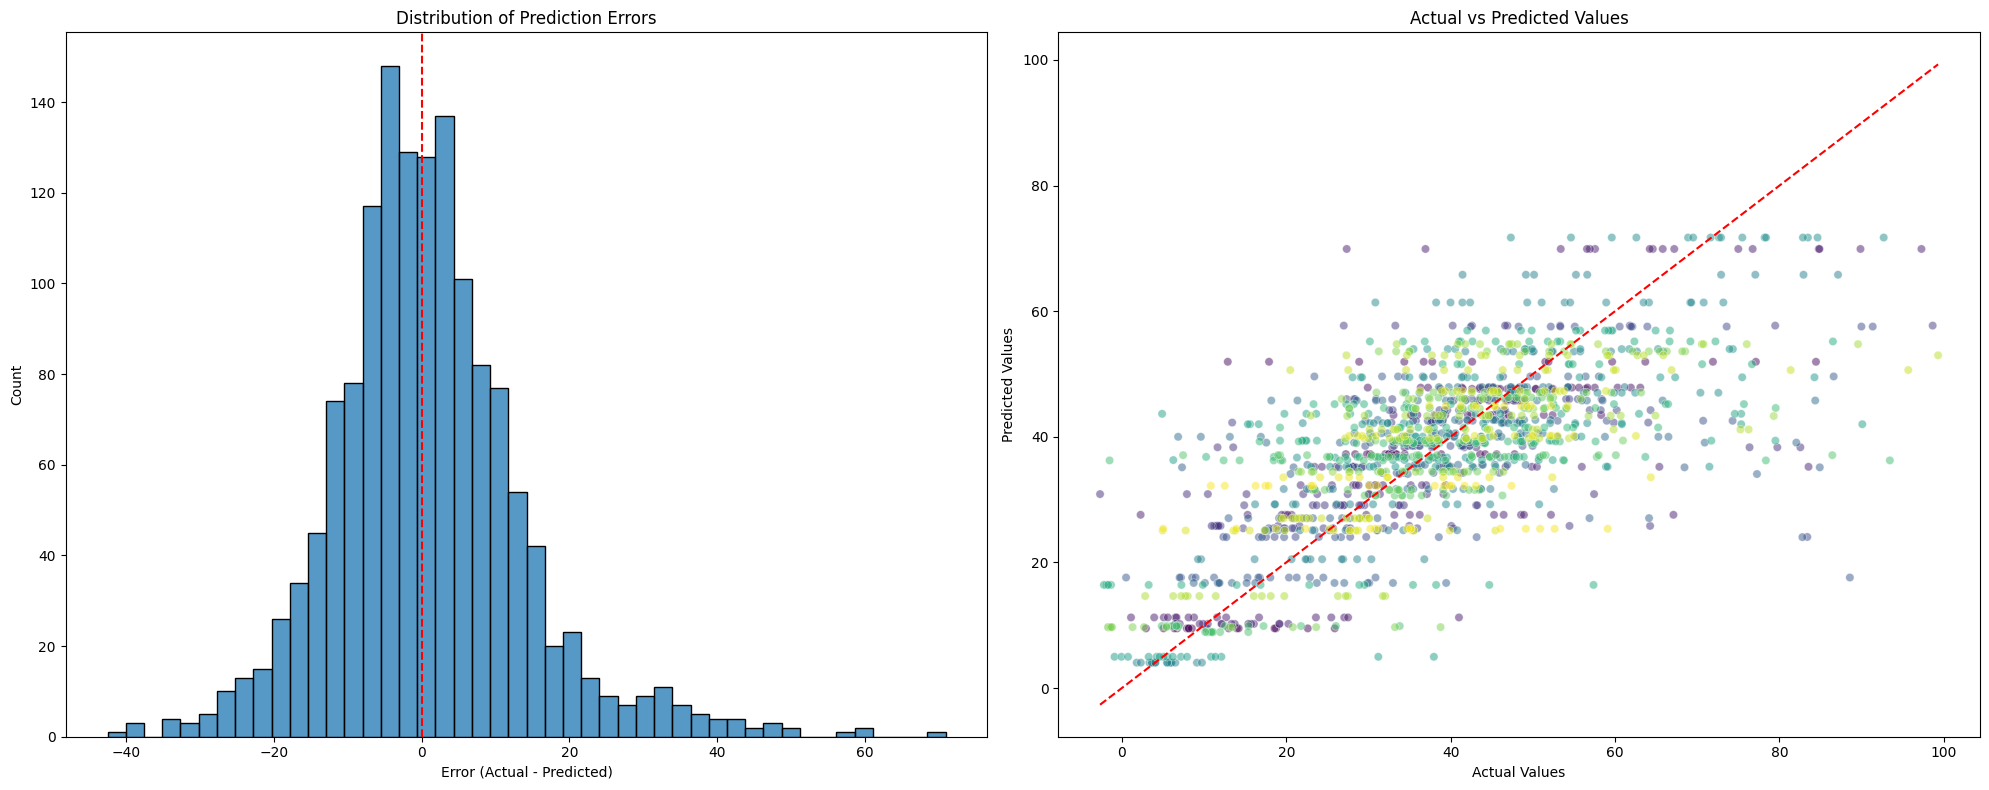

In [ ]:
# Drop NAs since not used for calculation
train_data_clean = train_data[[target, 'PID']].dropna()
test_data_clean = test_data[[target, 'PID']].dropna()

# Calculate median target value per subject from training data
train_medians = train_data_clean.groupby('PID')[target].median()

# Initialize predictions array
predictions = np.zeros(len(test_data_clean))

# Make predictions using each subject's median
for pid in test_data_clean['PID'].unique():
    # Get subject's data indices
    mask = test_data_clean['PID'] == pid
    
    # Use subject's training median if available, otherwise use overall median
    if pid in train_medians.index:
        subject_median = train_medians[pid]
    else:
        subject_median = train_data_clean[target].median()
        
    # Fill predictions for this subject
    predictions[mask] = subject_median

# Calculate metrics
mae = mean_absolute_error(test_data_clean[target], predictions)
rmse = np.sqrt(mean_squared_error(test_data_clean[target], predictions))
r2 = r2_score(test_data_clean[target], predictions)
mean_error = (mae + rmse)/2

# Print metrics
print(f"Baseline Model Performance Metrics:")
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f'Mean error: {mean_error:.4f}')
print(f"R²: {r2:.4f}")

# Print data sizes
print(f"\nData sizes:")
print(f"Training samples: {len(train_data_clean)}")
print(f"Test samples: {len(test_data_clean)}")
print(f"Number of subjects in training: {len(train_data_clean['PID'].unique())}")
print(f"Number of subjects in test: {len(test_data_clean['PID'].unique())}")

# Plot diagnostics
plot_model_diagnostics(test_data_clean[target], predictions, test_data_clean)


## Group Level Models

### MLM Models

In [117]:
target = 'target_wbw_gap_detrended'

In [118]:
train_data, test_data = create_train_test_split(df, target=target)

#### 1 Feature: Passive

In [148]:
# Find top passive feature with >1000 observations
top_passive = find_top_features(
    mlm1_4,
    n_predictors=1,
    data_modality='passive',
    min_observations=1000,
    sort_by='abs_z_score',
    top_n=1
)

Top 1 features for 1-predictor models with passive:
Minimum observations: 1000, Sorted by: abs_z_score

Results:

Rank 1:
Feature 1: passive_hk_activity_distanceWalkingRunning
abs_z_score: 6.573
z_score: -6.573
Number of observations: 1442


Model converged using lbfgs optimizer
                              Mixed Linear Model Regression Results
Model:                      MixedLM          Dependent Variable:          target_wbw_gap_detrended
No. Observations:           5907             Method:                      REML                    
No. Groups:                 104              Scale:                       180.9647                
Min. group size:            34               Log-Likelihood:              -23995.5325             
Max. group size:            61               Converged:                   Yes                     
Mean group size:            56.8                                                                  
--------------------------------------------------------------------------------------------------
                                                        Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------------------------------------------------
Int

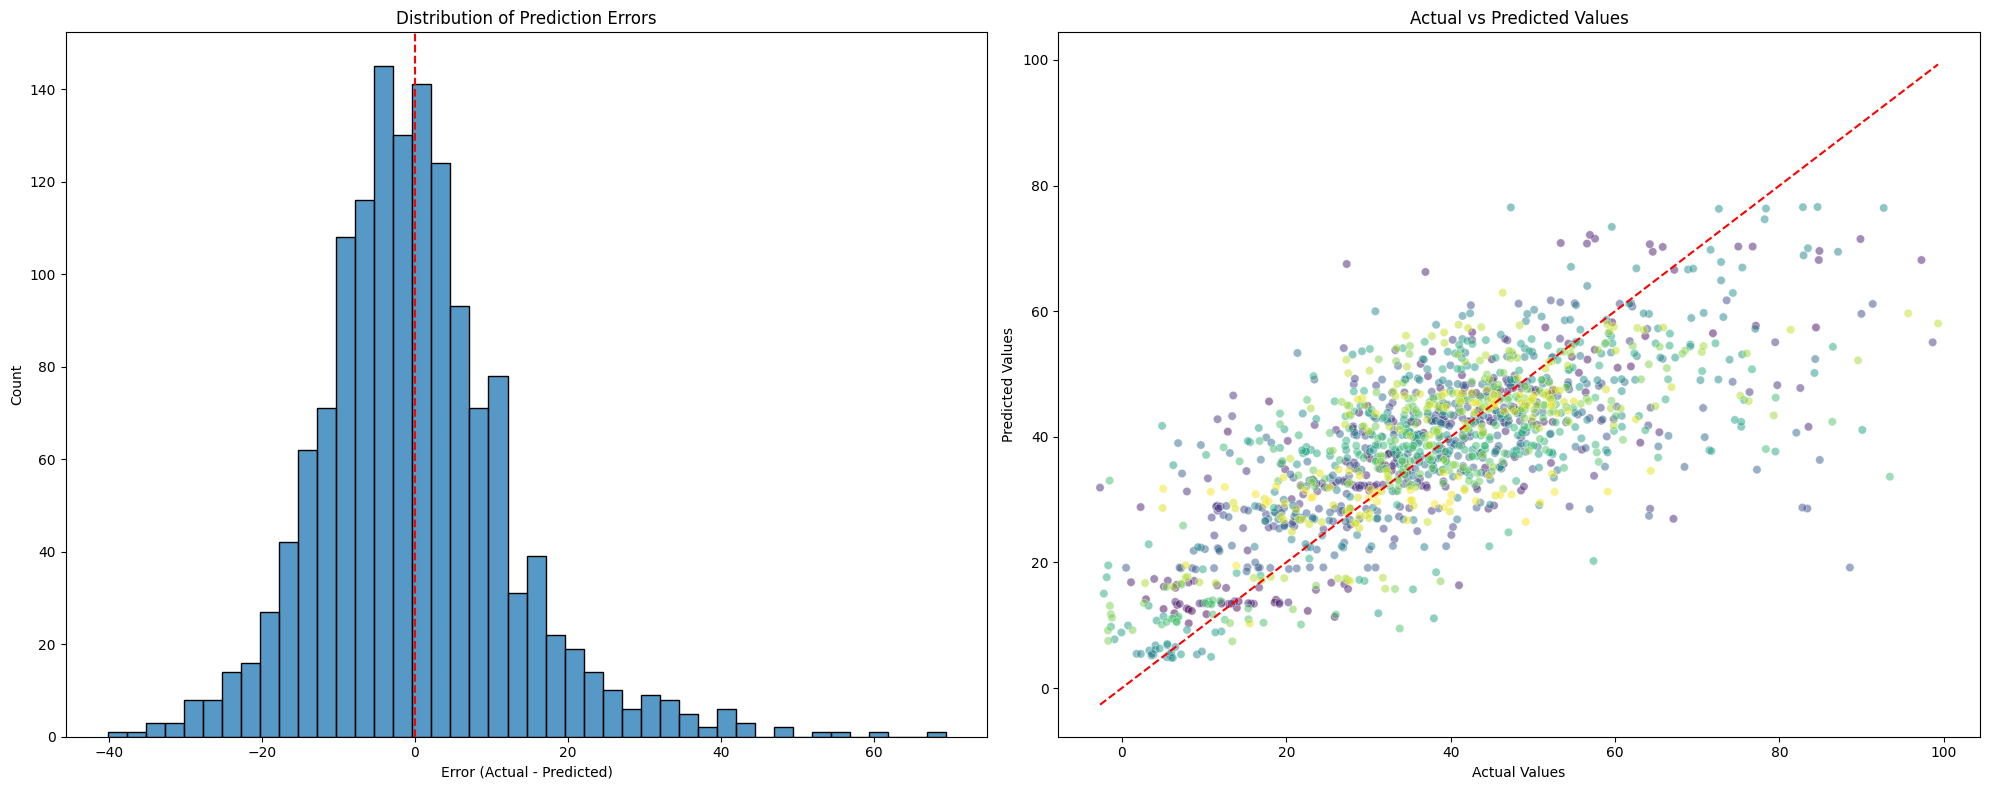

In [149]:
# Top passive feature MLM
predictors = ['passive_hk_activity_distanceWalkingRunning']

model, test_predictions, test_actual, train_predictions, train_actual, test_data_processed, train_data_processed = fit_and_predict_mlm(train_data, 
                                                                       test_data, 
                                                                       predictors=predictors, 
                                                                       target=target, 
                                                                       random_intercepts=True)

results = calculate_metrics(model=model,
                           test_predictions=test_predictions, 
                           test_actual=test_actual,
                           train_predictions=train_predictions,
                           train_actual=train_actual, 
                           test_data_processed=test_data_processed, 
                           train_data_processed=train_data_processed, 
                           target=target,
                           results=None,
                           verbose=False)

plot_model_diagnostics(test_actual, test_predictions, test_data_processed)

#### 1 Feature: Self Report

In [150]:
top_passive = find_top_features(
    mlm1_4,
    n_predictors=1,
    data_modality='sr',
    min_observations=1000,
    sort_by='abs_z_score',  # This is using raw z_score, not absolute
    top_n=1
)

Top 1 features for 1-predictor models with sr:
Minimum observations: 1000, Sorted by: abs_z_score

Results:

Rank 1:
Feature 1: sr_DAILY_past24_leisureSolo
abs_z_score: 7.892
z_score: 7.892
Number of observations: 1394


Model converged using lbfgs optimizer
                       Mixed Linear Model Regression Results
Model:                 MixedLM     Dependent Variable:     target_wbw_gap_detrended
No. Observations:      5752        Method:                 REML                    
No. Groups:            104         Scale:                  169.0375                
Min. group size:       22          Log-Likelihood:         -23171.7970             
Max. group size:       61          Converged:              Yes                     
Mean group size:       55.3                                                        
-----------------------------------------------------------------------------------
                                         Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------------------
Intercept                                38.464    1.288 29.868 0.000 35.940 40.988
sr_DAILY_past24_leisureSolo               2.234    0.283  7.8

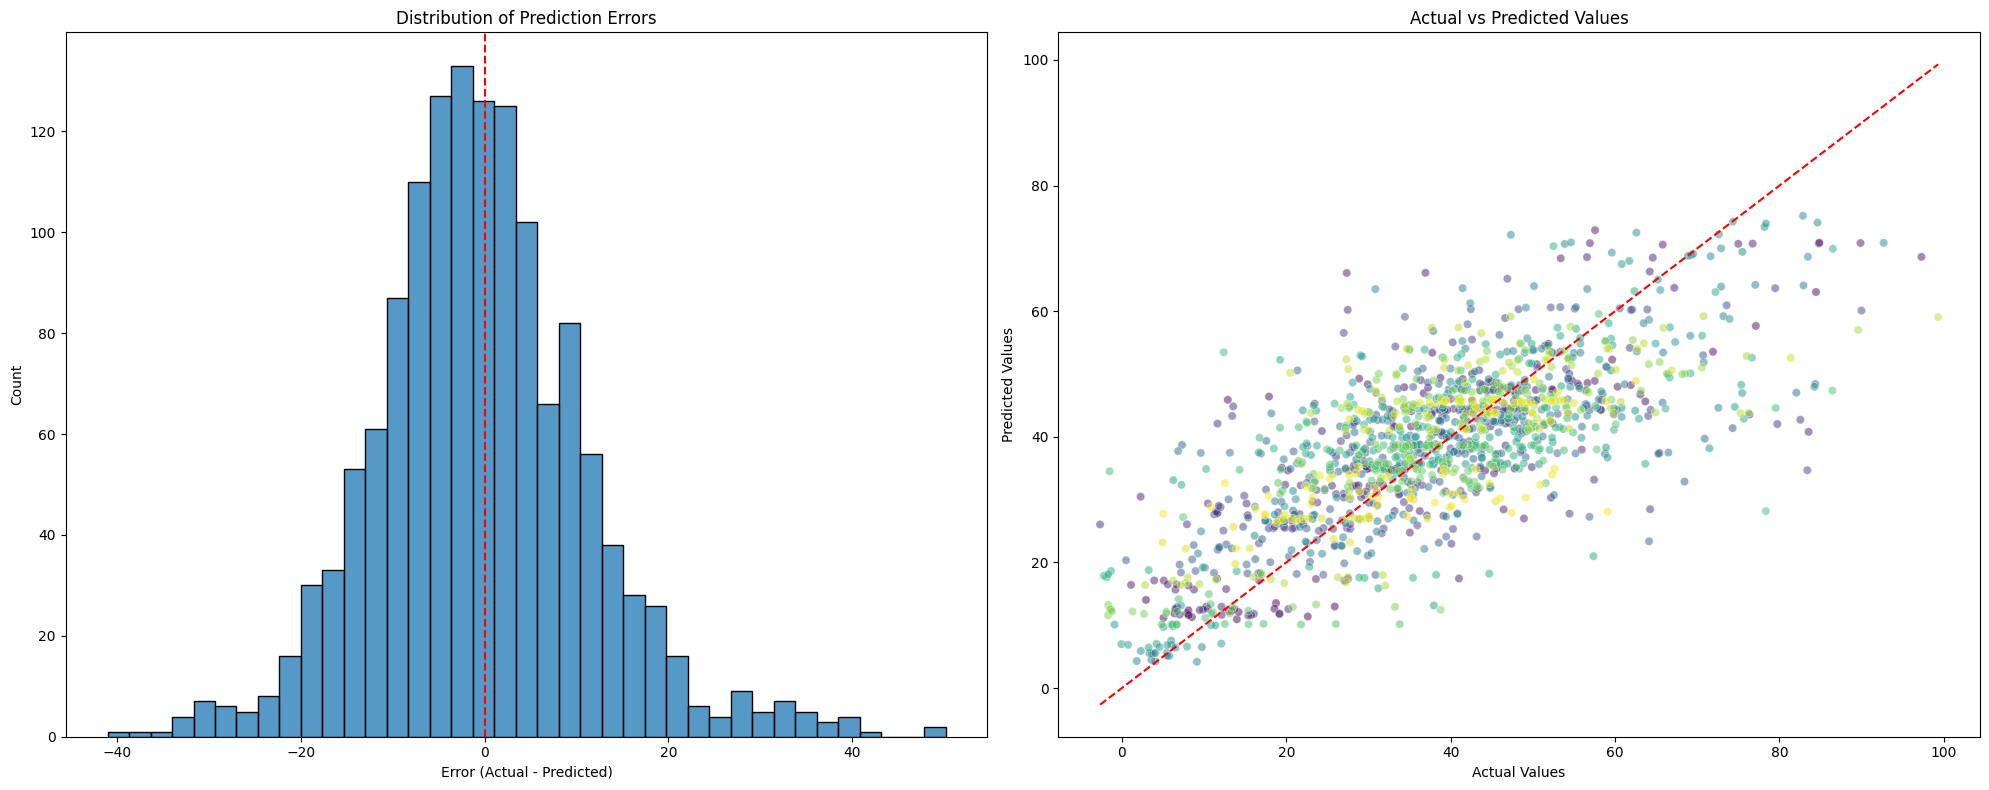

In [151]:
# Top sr feature MLM
predictors = ['sr_DAILY_past24_leisureSolo']

model, test_predictions, test_actual, train_predictions, train_actual, test_data_processed, train_data_processed = fit_and_predict_mlm(train_data, 
                                                                       test_data, 
                                                                       predictors=predictors, 
                                                                       target=target, 
                                                                       random_intercepts=True)

results = calculate_metrics(model=model,
                           test_predictions=test_predictions, 
                           test_actual=test_actual,
                           train_predictions=train_predictions,
                           train_actual=train_actual, 
                           test_data_processed=test_data_processed, 
                           train_data_processed=train_data_processed, 
                           target=target,
                           results=results,
                           verbose=False)

plot_model_diagnostics(test_actual, test_predictions, test_data_processed)

#### 2 Features: Passive

In [153]:
top_passive = find_top_features(
    mlm1_4,
    n_predictors=2,
    data_modality='passive',
    min_observations=1000,
    sort_by='mean_error',  
    top_n=1
)

Top 1 features for 2-predictor models with passive:
Minimum observations: 1000, Sorted by: mean_error

Results:

Rank 1:
Feature 1: passive_hk_activity_distanceWalkingRunning
Feature 2: task_start_time
mean_error: 10.6153
Number of observations: 1413


Model did not converge with lbfgs optimizer, trying next...
Model converged using nm optimizer
                                               Mixed Linear Model Regression Results
Model:                                  MixedLM                     Dependent Variable:                     target_wbw_gap_detrended
No. Observations:                       5145                        Method:                                 REML                    
No. Groups:                             104                         Scale:                                  180.6907                
Min. group size:                        14                          Log-Likelihood:                         -20932.8025             
Max. group size:                        61                          Converged:                              Yes                     
Mean group size:                        49.5                                                                                        
----------------------

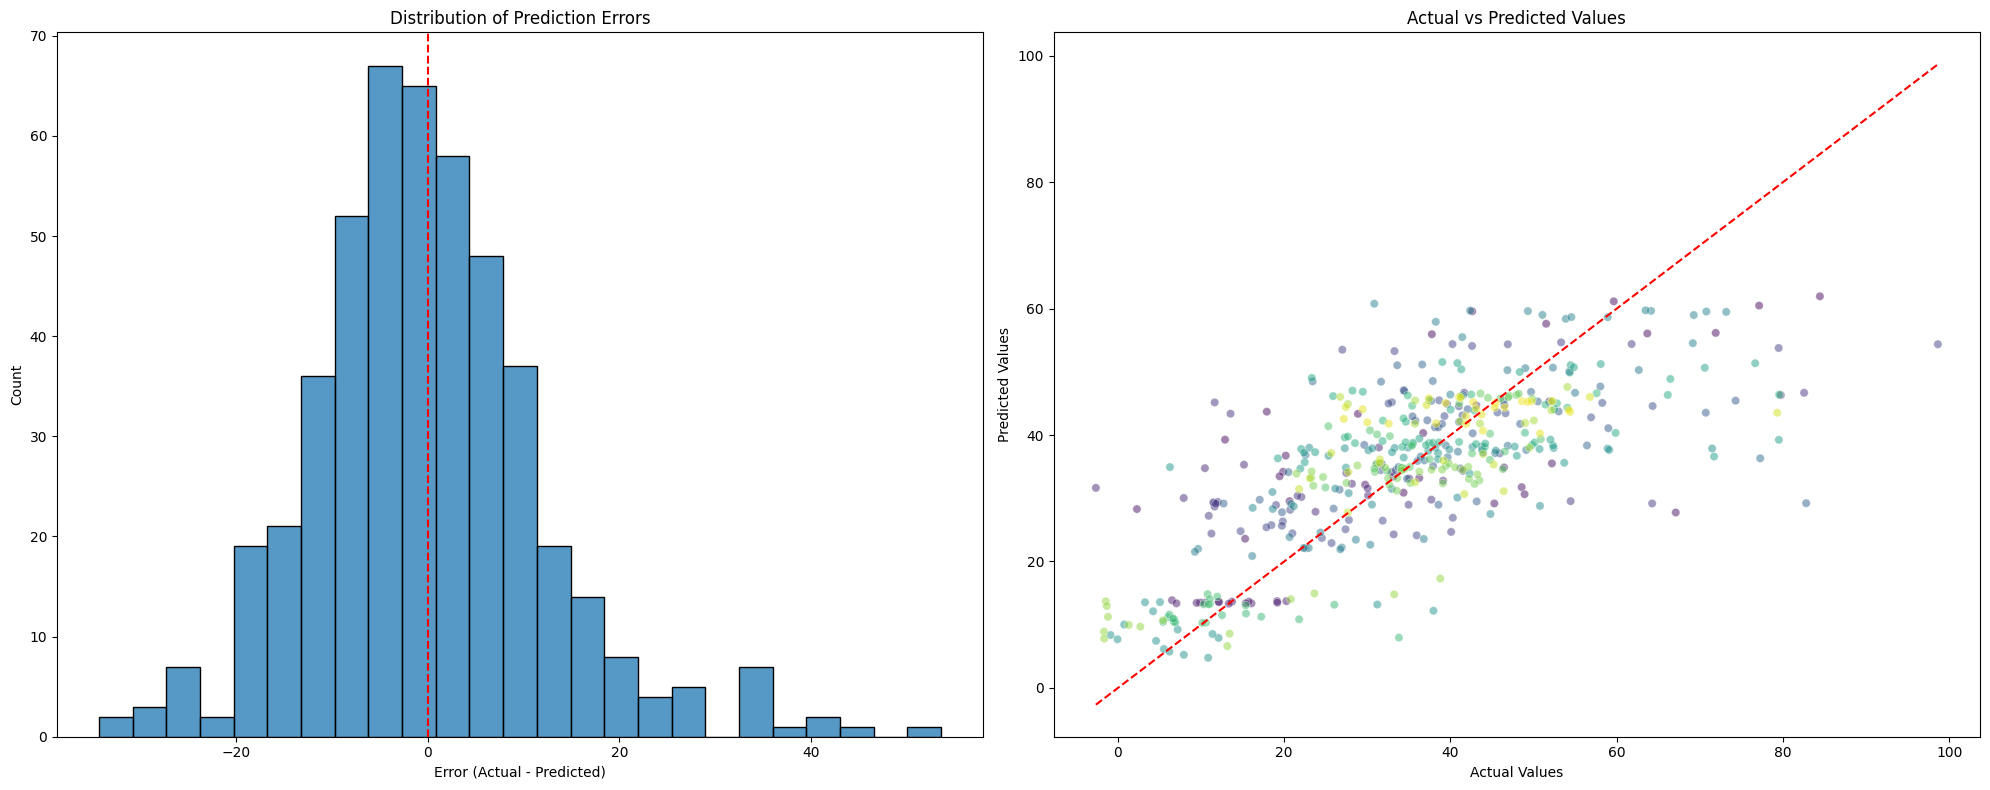

In [154]:
# Top passive feature MLM
predictors = ['passive_hk_activity_distanceWalkingRunning', 'passive_sk_device_total_unlock_duration']

model, test_predictions, test_actual, train_predictions, train_actual, test_data_processed, train_data_processed = fit_and_predict_mlm(train_data, 
                                                                       test_data, 
                                                                       predictors=predictors, 
                                                                       target=target, 
                                                                       random_intercepts=True)

results = calculate_metrics(model=model,
                           test_predictions=test_predictions, 
                           test_actual=test_actual,
                           train_predictions=train_predictions,
                           train_actual=train_actual, 
                           test_data_processed=test_data_processed, 
                           train_data_processed=train_data_processed, 
                           target=target,
                           results=results,
                           verbose=False)

plot_model_diagnostics(test_actual, test_predictions, test_data_processed)

#### 2 Features: Self Report

In [112]:
top_passive = find_top_features(
    mlm1_4,
    n_predictors=2,
    data_modality='self_report',
    min_observations=1000,
    sort_by='abs_z_score',  
    top_n=1
)

Top 1 features for 2-predictor models with self_report:
Minimum observations: 1000, Sorted by: abs_z_score

Results:

Rank 1:
Feature 1: sr_DAILY_past24_mentalEffort
Feature 2: sr_DAILY_past24_leisureNonSoloMental
abs_z_score: nan
z_score: nan
Number of observations: 1067


Model converged using lbfgs optimizer
                                       Mixed Linear Model Regression Results
Model:                           MixedLM                Dependent Variable:                target_wbw_gap_detrended
No. Observations:                4739                   Method:                            REML                    
No. Groups:                      103                    Scale:                             156.1270                
Min. group size:                 6                      Log-Likelihood:                    -18973.0057             
Max. group size:                 61                     Converged:                         Yes                     
Mean group size:                 46.0                                                                              
-------------------------------------------------------------------------------------------------------------------
                                                                         

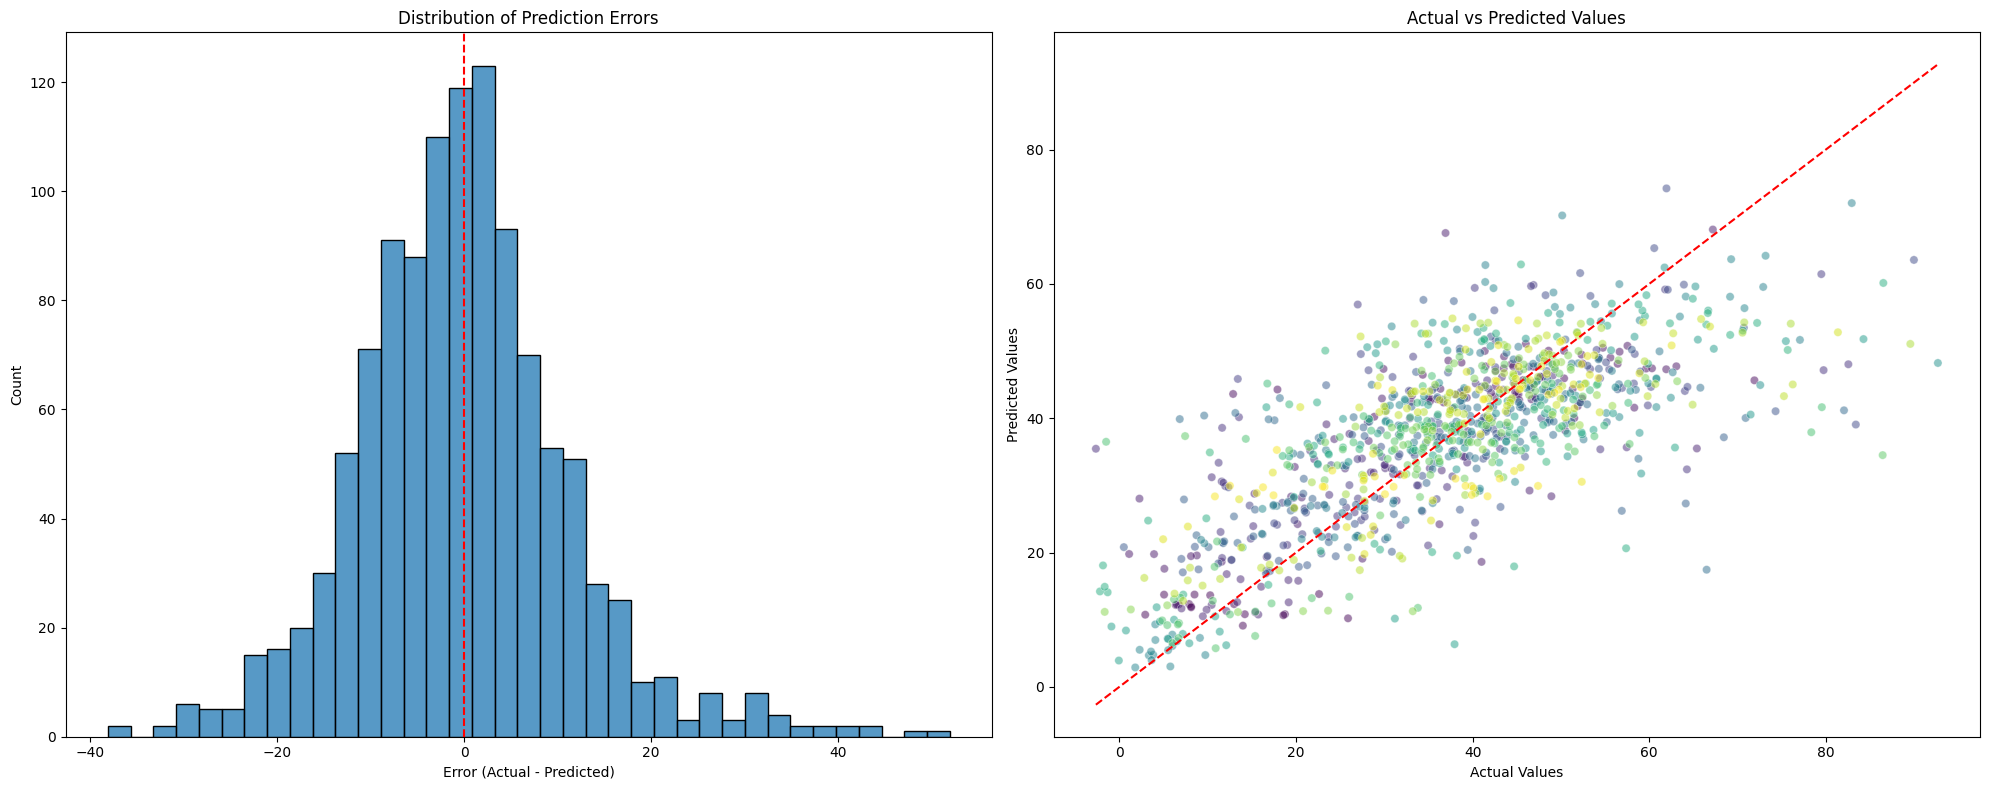

In [156]:
# Top passive feature MLM
predictors = ['sr_DAILY_past24_mentalEffort', 'sr_DAILY_past24_leisureNonSoloMental']

model, test_predictions, test_actual, train_predictions, train_actual, test_data_processed, train_data_processed = fit_and_predict_mlm(train_data, 
                                                                       test_data, 
                                                                       predictors=predictors, 
                                                                       target=target, 
                                                                       random_intercepts=True)

results = calculate_metrics(model=model,
                           test_predictions=test_predictions, 
                           test_actual=test_actual,
                           train_predictions=train_predictions,
                           train_actual=train_actual, 
                           test_data_processed=test_data_processed, 
                           train_data_processed=train_data_processed, 
                           target=target,
                           results=results,
                           verbose=False)

plot_model_diagnostics(test_actual, test_predictions, test_data_processed)

#### 2 Features: Passive + Self Report

Model converged using lbfgs optimizer
                                         Mixed Linear Model Regression Results
Model:                              MixedLM                 Dependent Variable:                 target_wbw_gap_detrended
No. Observations:                   5734                    Method:                             REML                    
No. Groups:                         104                     Scale:                              161.7229                
Min. group size:                    22                      Log-Likelihood:                     -23027.8844             
Max. group size:                    61                      Converged:                          Yes                     
Mean group size:                    55.1                                                                                
------------------------------------------------------------------------------------------------------------------------
                                    

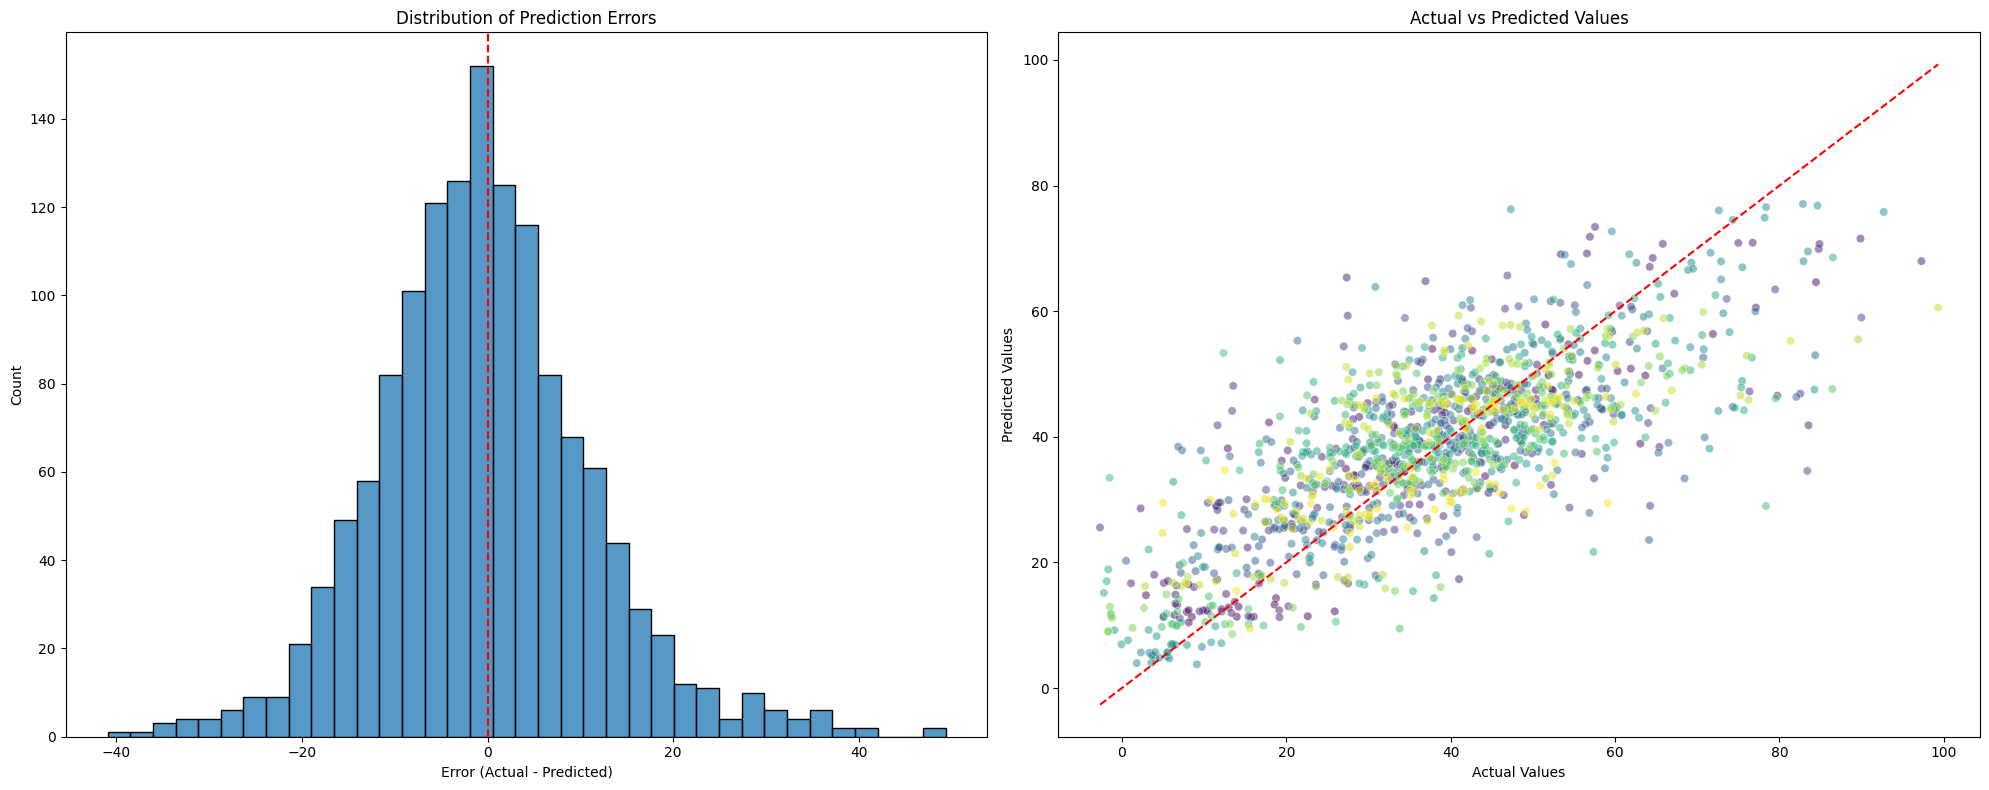

In [158]:
# Top passive feature MLM
predictors = ['sr_DAILY_past24_leisureSolo', 'passive_hk_activity_distanceWalkingRunning']

model, test_predictions, test_actual, train_predictions, train_actual, test_data_processed, train_data_processed = fit_and_predict_mlm(train_data, 
                                                                       test_data, 
                                                                       predictors=predictors, 
                                                                       target=target, 
                                                                       random_intercepts=True)

results = calculate_metrics(model=model,
                           test_predictions=test_predictions, 
                           test_actual=test_actual,
                           train_predictions=train_predictions,
                           train_actual=train_actual, 
                           test_data_processed=test_data_processed, 
                           train_data_processed=train_data_processed, 
                           target=target,
                           results=results,
                           verbose=False)

plot_model_diagnostics(test_actual, test_predictions, test_data_processed)

### MLM Results

In [159]:
results.head()

,target,n_predictors,predictors,data_modality,n_observations_train,n_observations_test,mae,rmse,mean_error,r2,...,direction_ci_lower_train,direction_ci_upper_train,high_gap_precision_test,high_gap_recall_test,high_gap_f1_test,high_gap_accuracy_test,high_gap_precision_train,high_gap_recall_train,high_gap_f1_train,high_gap_accuracy_train
0,target_wbw_gap_detrended,1,[passive_hk_activity_distanceWalkingRunning],passive,5907,1442,9.331799,12.572895,10.952347,0.516924,...,0.537127,0.563161,0.396552,0.050773,0.090020,0.677531,0.485294,0.082008,0.140306,0.657694
1,target_wbw_gap_detrended,1,[sr_DAILY_past24_leisureSolo],sr,5752,1394,8.833590,11.694691,10.264141,0.554891,...,0.538947,0.565687,0.428571,0.069124,0.119048,0.681492,0.550388,0.108729,0.181586,0.666203
2,target_wbw_gap_detrended,2,"[passive_hk_activity_distanceWalkingRunning, p...",passive,5145,479,9.003355,12.139074,10.571215,0.512453,...,0.541162,0.567149,0.521739,0.080000,0.138728,0.688935,0.484419,0.097547,0.162393,0.657143
3,target_wbw_gap_detrended,2,"[sr_DAILY_past24_mentalEffort, sr_DAILY_past24...",sr,4739,1132,8.496377,11.389728,9.943053,0.540642,...,0.567731,0.594699,0.378378,0.078873,0.130536,0.670495,0.540616,0.119801,0.196138,0.666174
4,target_wbw_gap_detrended,2,"[sr_DAILY_past24_leisureSolo, passive_hk_activ...",passive_sr,5734,1388,8.759933,11.552256,10.156094,0.566508,...,0.561985,0.588099,0.466667,0.097448,0.161228,0.685159,0.554307,0.151795,0.238325,0.670038


### XGBoost

### GPBoost

## Individual Level Models

Given that we are collecting ILD we can also consider fitting models at the individual level.

This allows us to leverage the fact that individual differences mean that predictors with no meaningful group level signal may have important individual level signal.

### Linear Regression

## Ensemble Models

### Individual Linear Regression + Best Group Level Model